<a href="https://colab.research.google.com/github/yajuna/tensorflow_pde/blob/master/acoustic_dispersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this notebook, we implement the PINN methodology by Raissi to solve the acoustic wave equation with finite difference methods and aim to identify the best Finite Difference schemes for computing wave speed.

The main reference are Raissi's original paper, Jan Schmidt's notebooks, and _A convolutional dispersion relation preserving scheme for the acoustic wave equation_ by  Oded Ovadia et al.

The acoustic wave differential equation assumes the form

$u_{tt}=c^2u_{xx}$

We discretize the above equation with the Finite Difference (FD) method.

\begin{equation} U^{n + 1}_j + U^{n - 1}_j  + \sum^M_{m = 0} c_m  (U^n_{j + m}+ U^n_{j - m}) = 0\end{equation}

An example with $M=1$ is the familiar Leap-Frog scheme

\begin{equation} U^{n + 1}_j - 2 U^n_j + U^{n - 1}_j - \gamma^2  \left(U^n_{j + 1} - 2 U^n_j +U^n_{j - 1}\right) \approx 0,\end{equation}

where $\displaystyle\gamma = c \frac{\Delta t}{\Delta x}$ denotes the CFL number, $U^{n + l}_{j + m}$ denotes the grid function approximating $u (x +m\Delta x, t + l \Delta t)$ and $U^n_j$ the center point at the present time $u(x,t)$. This discretization enforces 2nd order accuracy at $(x,t)$. Let $k$ denote the physical wave number and $\omega$ the physical frequency and $\Omega=\omega\Delta t$ and $K=k\Delta x$ denote the normalized numerical frequency and normalized numerical wavenumber. Here $K\in[0,\pi]$, with $K_{max}=\pi$ being the Nyquist wavenumber.
Applying the discrete Fourier transform ($x\to K$, $t\to\Omega$) to the general scheme gives the dispersion relation

\begin{equation}\cos (\Omega) + \sum^M_{m = 0} c_m \cos (m K) = 0,\end{equation}

and we aim to find the coefficients $\{c_m\}^M_{m=0}$ with a physics informed neural network.

Previous work has been done to find such schemes with optimization methods, and in this work, we frame the problem to be an identification problem with the physics-informed neural network methodology.

The physics information will be accuracy of the solution with the FD scheme for the initial and boundary conditions, preset interpolation conditions, as well as dispersion in the uniform norm.

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas

from time import time

from IPython.display import clear_output

clear_output()

## Set hyperparameters

In [37]:
# set data type and hyperparameters
# import data

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

pi = tf.constant(np.pi, dtype = DTYPE)

# Set number of data points
N_0 = 400 # number of points in space; same as N_0 for simplicity
N_b = 400 # number of points in time; this is the amount of measurements in 24 hours
N_r = 100

# Set boundary
tmin = 0.
tmax = 24.
xmin = 0.
xmax = 3.

dt = (tmax - tmin)/N_b

# wave speed
c = 1
gamma = 0.7

# Lower bounds in time and space
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds in time and space
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data; need N_0 == N_b for concat
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_init = tf.linspace(lb[1], ub[1], N_0)
x_0 = tf.reshape(x_init, (N_0,1))
X_0 = tf.concat([t_0, x_0], axis=1)

# Boundary data- left and right boundary compared for periodic bdry condition
t_boundary = tf.linspace(lb[0], ub[0], N_b)
t_b = tf.reshape(t_boundary, (N_b,1))
x_lb = tf.ones((N_b,1), dtype=DTYPE)*lb[1]
x_ub = tf.ones((N_b,1), dtype=DTYPE)*ub[1]
X_lb = tf.concat([t_b, x_lb], axis=1)
X_ub = tf.concat([t_b, x_ub], axis=1)


# # Draw uniformly sampled collocation points
# t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
# x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
# X_r = tf.concat([t_r, x_r], axis=1)

# Draw grid points for the discrete parameter identification problem
t_r1 = tf.linspace(lb[0], ub[0], N_r)
x_r1 = tf.linspace(lb[1], ub[1], N_r)

t_r, x_r = tf.meshgrid(t_r1, x_r1)
X_r = tf.concat([t_r, x_r], axis=1)

### Define the true solution to the wave equation
We use the function $u_{true}(x,t)=\phi(x,t)=\sin(2\pi\xi(x-ct))e^{-\beta(x-ct-0.5)^2}$ as the analytical solution to the wave equation.

We would like to see 8 points per wavelength, so $\xi\Delta x = \frac{2\pi}{8}$.

Here we take $\beta = 16$, $2\pi\xi = 125.7$, and $c=1$.

In [30]:
c = 1
beta = 16
pi2xi = 125.7
def utrue(x,t):
  xat = (x - c * t) % 3
  return np.sin(pi2xi * xat) * np.exp(-beta * (xat - 0.5)**2)

In [40]:
# define initial conditions
u_0 = utrue(x_0, t_0)
u_01 = utrue(x_0, t_0 + dt)
# plt.figure(1)
# plt.plot(x_0, u_0, 'b')
# plt.figure(2)
# plt.plot(x_0, u_01, 'g')

In [ ]:
# # test analytical solution
# x = np.linspace(xmin, xmax, 50)
# t = np.linspace(tmin, tmax, 19)
# for time in t:
#   u = utrue(x,time)
#   plt.figure(1)
#   plt.plot(x,u,'k')
#   plt.show()

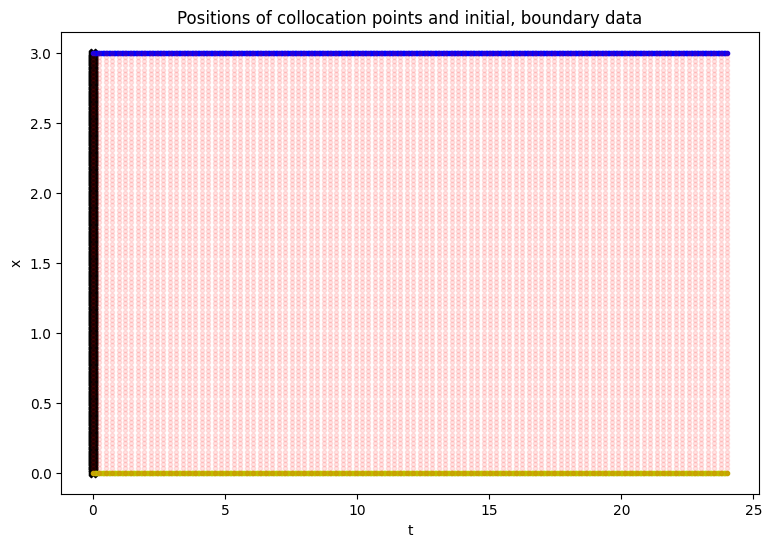

In [33]:
# plot grid points
fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c='k', marker='X')
plt.scatter(t_b, x_lb, c='y', marker='.')
plt.scatter(t_b, x_ub, c='b', marker='.')
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('t')
plt.ylabel('x')

plt.title('Positions of collocation points and initial, boundary data');

In [34]:
# define residual of PDE
def fun_r():
  return

In [29]:
N_r = 3

t_r1 = tf.linspace(lb[0], ub[0], N_r)
x_r1 = tf.linspace(lb[1], ub[1], N_r)

t_r, x_r = tf.meshgrid(t_r1, x_r1)
X_r = tf.concat([t_r, x_r], axis=1)
# print(t_r, x_r)
# print(X_r)

# N_b = 3
# t_boundary = tf.linspace(lb[0], ub[0], N_b)
# t_b = tf.reshape(t_boundary, (N_b,1))
# x_lb = tf.ones((N_b,1), dtype=DTYPE)*lb[1]
# x_ub = tf.ones((N_b,1), dtype=DTYPE)*ub[1]
# X_lb = tf.concat([t_b, x_lb], axis=1)
# X_ub = tf.concat([t_b, x_ub], axis=1)
# print(X_ub)